# Notebook for Canada data

*This is a submission for the IBM-Coursera Data Science course - Applied Data Science Capstone*

----

## The following cells relate to items 1-4 in the assigment ##

In [1]:
#import libraries
!pip install --user pandas==1.0.5 #default version did not have json_normalize
import pandas as pd

!pip install --user numpy==1.16.4 #default version incompatible with pandas 1.0.5
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import random
import urllib.request

     |████████████████████████████████| 10.1MB 8.8MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
     |████████████████████████████████| 17.3MB 6.8MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
# define source data website
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urllib.request.urlopen(url)

In [3]:
# get library for html parsing -- use parser 'lxml'
from bs4 import BeautifulSoup
soup = BeautifulSoup(page, "lxml")

In [4]:
# as there is only one table on the webpage, this returns a unique table
post_tables=soup.find('table', class_='wikitable sortable')


In [5]:
# scrape table
# establish empty lists for 3 columns of desired data
PC =[]
Borough =[]
Neigh =[]

# add data to lists
for row in post_tables.findAll(r'tr'):
    cells = row.findAll(r'td') #finds all occurences of 'td' and makes a list of them
    if len(cells)==3:
        PC.append(cells[0].find(text=True))
        Borough.append(cells[1].find(text=True))
        Neigh.append(cells[2].find(text=True))

In [6]:
# create dataframe from lists
df=pd.DataFrame(PC, columns=['Postalcode'])
df['Borough']=Borough
df['Neighborhood']=Neigh


In [7]:
# inspect dataframe
print(df.shape)
print(df.columns)
print(df["Borough"].unique())
print(df["Neighborhood"].nunique())

(180, 3)
Index(['Postalcode', 'Borough', 'Neighborhood'], dtype='object')
['Not assigned\n' 'North York\n' 'Downtown Toronto\n' 'Etobicoke\n'
 'Scarborough\n' 'East York\n' 'York\n' 'East Toronto\n' 'West Toronto\n'
 'Central Toronto\n' 'Mississauga\n']
100


In [8]:
# strip out unwanted \n from entries
df.replace('\n', '', regex=True, inplace=True)

In [9]:
# Eliminate post codes that are 'not assigned'
df1=df[df.Borough != 'Not assigned']
df1.head(10)

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [10]:
# check: is any postalcode assigned to more than one neighborhood
print('Total number of post codes minus number of unique p.c.=', df1["Postalcode"].count()-df1["Postalcode"].nunique())

ls =[]
ls_dup =[]
for i in df1["Postalcode"]:
    if i in ls: 
        ls_dup.append(i)
    ls.append(i)

print("Post codes appearing more than once:", ls_dup)


Total number of post codes minus number of unique p.c.= 0
Post codes appearing more than once: []


In [11]:
df1.shape

(103, 3)

## End of section related to questions 1-4

-----

# Begin un-numbered portion of assingment
## + Assign latitude and longitude
## + Cluster based on Foursquare data
## + Place clusters on maps

----

## Assign lat and long

In [12]:
# giving up on geocoders and just downloading the csv file provided in the assignment

geo = pd.read_csv('http://cocl.us/Geospatial_data')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# combine the lon,lat data from cell above with the wikipedia page post code data
df2 = df1.merge(geo, how="outer", right_on="Postal Code", left_on="Postalcode")
df2.head()

,Postalcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494


In [14]:
# ensure data match
a = df2["Postal Code"] == df2["Postalcode"]
a.all()

True

In [15]:
# drop column Postal Code
df2.drop("Postal Code", axis=1, inplace=True)
df2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## Now cluster neighborhoods based on Foursquare ##

*Properties relevant for clustering*

*1. Vegetarian restaurant*
*2. Bookstore*
*3. Rock climbing gym*
*4. Wine bar*

In [16]:
# libraries
import requests
import json

In [17]:
# query foursquare for venues based on locations, where locations are specified by using neighborhood lat, long

# define static parameters for foursquare API cll
client_id = 'TLYOVL14TKQ5PDL1XJ1QMVPXVNLDAAE3AW1DDLMEKLCOIG1S'
client_secret = ''
version= 20160602
radius = 2000 #2km radius
limit = 50
search_query = ["Vegetarian", "Bookstore", "Climbing", "Wine Bar"]

# loop through each criterion
for search_query in search_query:
    #add a new column in the df
    df2[search_query]=''

    #loop through each neighborhood
    for nhood in range(len(df2.index)):
        
        #for each neighborhood, find latitude and longitude
        latitude = df2.iloc[nhood,df2.columns.get_loc('Latitude')]
        longitude = df2.iloc[nhood,df2.columns.get_loc('Longitude')]
        
        # for each lat, long find search for nearby venues matching search_query
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            client_id, client_secret, latitude, longitude, version, search_query, radius, limit)

        r = requests.get(url).json()["response"]
        #print(json.dumps(r,indent=4))
        venues = r['venues']
        venues_df = pd.json_normalize(venues)
        criterion = len(venues_df.index)
            
        df2.iloc[nhood, df2.columns.get_loc(search_query)] = criterion
    
df2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Vegetarian,Bookstore,Climbing,Wine Bar
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,1,0,23
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,2,1,33
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,12,0,50
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,0,0,50
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,7,23,2,50
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0,0,0,13
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,1,1,7
7,M3B,North York,Don Mills,43.745906,-79.352188,0,0,0,30
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,0,1,50
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,5,20,1,50


*Having loaded the relevant venue data into the data frame, create neighborhood clusters using K Means*

In [18]:
# k-means clustering

# import libraries
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

# use a reduced data frame containing only the 4 criteria used to cluser and save it as numpy array
df3 = df2[["Vegetarian", "Bookstore", "Climbing", "Wine Bar"]]
df3_array= df3.to_numpy()

# normalize the data
df3_array = preprocessing.StandardScaler().fit(df3_array).transform(df3_array)

# intialize tool for 5 clusters, try 12 intitial starting conditions
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)

# fit
k_means.fit(df3_array)

k_means_labels = k_means.labels_
print(k_means_labels)

[1 3 0 3 4 1 1 1 3 4 3 1 1 1 3 0 3 1 1 3 0 3 1 3 4 2 3 1 1 1 0 2 1 1 1 3 0
 2 1 1 3 3 4 3 1 1 1 3 0 1 1 1 3 1 3 3 3 1 1 3 1 3 3 3 1 1 3 3 3 3 1 1 1 3
 4 3 1 1 3 3 4 3 1 3 4 0 3 3 1 1 1 3 0 3 1 1 0 0 3 4 3 3 3]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


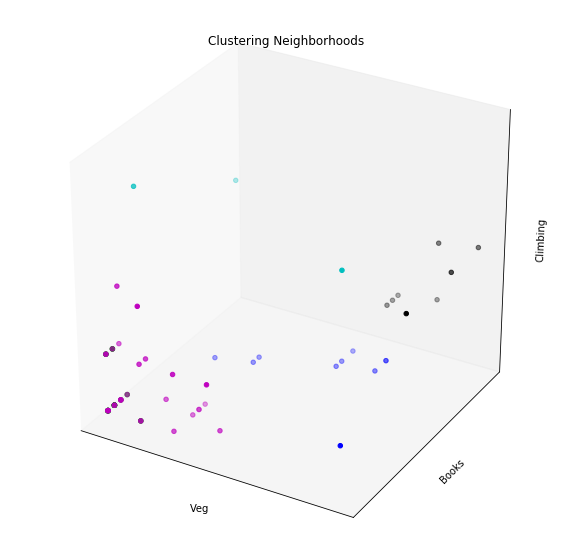

In [19]:
# visualize clusters (using only 3 of the 4 criteria because of plotting limitations)

fig = plt.figure(figsize=(10,10))
how_many_clusters = len(set(k_means_labels))
#colors = plt.cm.Spectral(np.linspace(0,1,how_many_clusters))
colors = ['b', 'g', 'c', 'm', 'k']

ax=fig.add_subplot(1,1,1, projection='3d')

# loop data points
for k, col in zip(range(how_many_clusters), colors):
        #create list of all data points, if data in cluster then True
        my_members = (k_means_labels == k)
        # plot data point with correct color
        #style=dict(marker='o', markerfacecolor = col)
        ax.scatter(df3_array[my_members, 0], # vegetarian restaurants
                   df3_array[my_members, 1], # bookstores
                   df3_array[my_members,2], # wine bars
                   c=col)

ax.set_title("Clustering Neighborhoods")
ax.set_xlabel('Vegetarian')
ax.set_ylabel('Books')
ax.set_zlabel('Climbing')
ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())


plt.show()

In [25]:
# add a column to the data frame with neighborhood clusters

# where to add the new column... find the rightmost column
place = df2.shape[1]

#what to call the new column
name_new = 'Cluster'

#insert cluster assignments
df2.insert(place,name_new, k_means_labels)
df2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Vegetarian,Bookstore,Climbing,Wine Bar,Cluster
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,1,0,23,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,0,2,1,33,3
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,12,0,50,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,0,0,50,3
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,7,23,2,50,4
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242,0,0,0,13,1
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,1,1,7,1
7,M3B,North York,Don Mills,43.745906,-79.352188,0,0,0,30,1
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,0,0,1,50,3
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,5,20,1,50,4


## Plot like neighborhoods on map

In [26]:
# import libraries
!conda install -c conda-forge folium=0.5.0 --yes
import folium


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                       

In [32]:
# create basemap

lat_map = df2.iloc[0,df2.columns.get_loc('Latitude')]
lon_map = df2.iloc[0,df2.columns.get_loc('Longitude')]

t_map = folium.Map(
location = [lat_map, lon_map],
zoom_start=12,
tiles='Stamen Toner')

In [41]:
# make popup for each neighborhood

for pc, lat, lon, c in zip(df2['Postalcode'], df2['Latitude'], df2['Longitude'], df2['Cluster']):
    # label for neighborhood marker / popup
    text = pc + ' is in cluster ' + str(c)
    # color for neighborhood marker
    colors = ['red', 'blue', 'green', 'purple', 'orange'] #allowable folium colors are different than pyplot colors
    marker_color = colors[c]
    
    # create markers
    folium.Marker(
    location = [lat, lon],
    popup=text,
    icon=folium.Icon(icon='bolt', color=marker_color, prefix='fa')
    ).add_to(t_map)

t_map